# SSPALS signal-to-noise ratio

<span style="color:red">IMPORTANT</span> - This notebook reads HDF5 files. Always PAUSE Sequencer.vi to run analysis for current sequence (HDF5 r/w conflict)!

In [1]:
#import python packages
import os
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
%matplotlib inline
import sspals
import oskar

### Import

In [2]:
rid = '20160311_121805'
h5 = oskar.H5Data(rid)              # data
h5.load_log()
vDF = h5.var_df()
uDF = h5.unique_df()
out_dire = h5.out_dire("Traces")    # output
h5.pprint()

20160311_121805
   Author:	 AA, AD
   Description:  n = 45 on/off


In [3]:
uDF.head()

,DLY_EA,IR,VOL_u100,VOL_u101
VID,,,,
1,5.950000e-07,729.6791,4000,3950
2,5.950000e-07,749.2000,4000,3950


In [4]:
# params
VIDS = np.array([1, 2])
channels = [['CH_L0', 'CH_L1'],
            ['CH_L2', 'CH_L3']]
limits = [[-1e-8, 2.5e-7, 6.5e-7],
          [-1e-8, 3.5e-7, 6.5e-7]]
# get data
dtype=[('t0','float'),('AC','float'),('BC','float'),('DF','float')]
DF = pd.DataFrame(np.array([],dtype=dtype))
data = dict()
max_num = 1000           # maximum number of squids to include
for vid in tqdm(VIDS):
    i = 0
    for chan in channels:
        squids = vDF[(vDF == uDF.loc[vid]).all(1)].index.values[:max_num]
        hi, osc_hi = h5.load_array(squids, chan[0], ignore_missing=True)
        low, osc_low = h5.load_array(squids, chan[1], ignore_missing=True)
        dt = osc_hi['dt']
        chmx = sspals.chmx(hi, low, invert=True, n_bsub=100,
                           validate=True, min_range=0.1)
        # sspals
        DF = sspals.sspals(chmx, dt, limits=limits[i])
        x = (np.arange(np.shape(chmx)[1])*dt) - DF.t0.mean()
        data[str(vid) + ":" + chan[0]] = {'x':x, 'y':chmx, 'DF':DF}
        i = i + 1

In [5]:
all_dat = dict()
for chan in channels:
    signal = []
    signal_err = []
    # background
    bk_vid = 2
    # signal
    vid = 1
    num = min(len(data[str(bk_vid) + ":" + chan[0]]['DF'].index),
              len(data[str(vid) + ":" + chan[0]]['DF'].index))
    for rep in trange(num):
        dat_on = data[str(vid) + ":" + chan[0]]['DF'].loc[0:rep, 'DF']
        av_on = dat_on.mean()
        stderr_on = dat_on.std() / np.sqrt(rep)
        dat_off = data[str(bk_vid) + ":" + chan[0]]['DF'].loc[0:rep, 'DF']
        av_off = dat_off.mean()
        stderr_off = dat_off.std() / np.sqrt(rep)
        S, S_err = sspals.signal(av_on, stderr_on, av_off, stderr_off)
        signal.append(S)
        signal_err.append(S_err)
    signal = np.array(signal)
    signal_err = np.array(signal_err)
    all_dat[chan[0]] = [signal, signal_err]

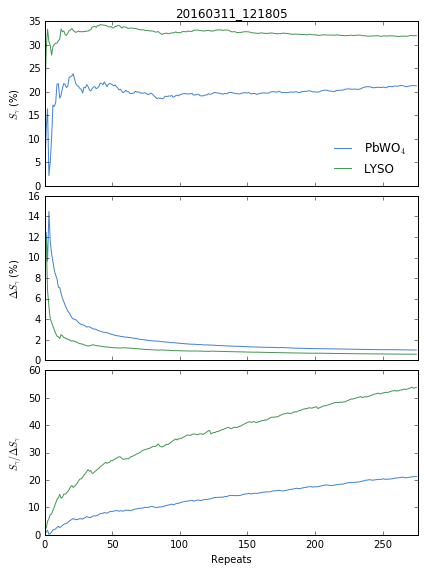

In [6]:
# plot setup
fig, ax = plt.subplots(3, 1, figsize=(6,8))

#plot
labels = [r'PbWO$_4$', 'LYSO']
for i, chan in enumerate(channels):
    signal, signal_err = all_dat[chan[0]]
    repeats = np.arange(len(signal))
    ax[0].plot(repeats, signal, label=labels[i], color=oskar.colors[i%7])
    ax[1].plot(repeats, signal_err, color=oskar.colors[i])
    ax[2].plot(repeats, np.divide(signal, signal_err), color=oskar.colors[i%7])


# plot range
ax[2].set_xlim(0, len(signal))
ax[0].set_xlim(ax[2].get_xlim())
ax[1].set_xlim(ax[2].get_xlim())
    
#format
ax[0].set_title(rid)
ax[0].set_ylabel("$S_\gamma$ (%)");
ax[1].set_ylabel("$\Delta S_\gamma$ (%)");
ax[2].set_ylabel("$S_\gamma / \Delta S_\gamma$");
ax[2].set_xlabel(r"Repeats");
plt.setp(ax[0].get_xticklabels(), visible=False)
plt.setp(ax[1].get_xticklabels(), visible=False)
lgd = ax[0].legend(loc=0, frameon=False)

plt.tight_layout(h_pad=0.1)
fileout = os.path.join(out_dire, "snr.png")
plt.savefig(fileout, dpi=600, bbox_inches='tight')
plt.show()